In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:

random.seed(0)
np.random.seed(0)
num_data = 10000
num_features = 10
x = np.random.randn(num_data, num_features)
weights = np.random.randn(num_features)
bias = 5.0
# w = np.zeros(num_features)
# b = np.zeros(1)
y = x @ weights + bias + np.random.randn(num_data) * 0.0 + (x.sum(1) > 0) * .5 + \
    (x[:,2] > .2) * 13.5 + (x[:,1] * x[:,2]) * 5.0
y = (y - y.mean())/ (y.std())

In [3]:
## **** Alternative (XOR) dataset
# num_data = 100
# num_features = 2
# x = np.random.randint(2, size=(num_data, num_features))
# y = (x.sum(1) % 2 == 1).astype(float)

In [4]:
## ****  This was our V1 linear regression model
# losses = []
# for _ in range(1000):
#     yhat = x @ w + b
#     err = y - yhat
#     w = w + (err @ x) * 1e-5
#     loss = np.square(err).mean()
#     losses.append(loss)
#     b += err.sum() * 1e-5

In [5]:
# gradient = how much do you want to impact the prediction * how much does your change impact the prediction
# gradient = desired_impact_change * effectiveness_of_changing_parameter

In [6]:
# 1 - fully implement current codebase
#     - start with code cleaning, then implement momentum
#     ** - Lee code cleans offline, group implments momentum, nesterov momentum, minibatch sampling
# 2- implement convolution and stuff like it in numpy
# 3- conv in tensorflow

In [7]:
class LeakyRelu:
    def __init__(self):
        pass
    def forward(self, x):
        self.x_last = x
        ret = np.maximum(x, .3 * x)
        return ret
    def backward(self, err, *args, **kwargs):
        return err * ((self.x_last > 0) + (self.x_last < 0) * .3)

In [8]:
class DenseNp:
    def __init__(self, in_shape, out_shape, l2_reg = 1e-5, initialization = 'xavier'):
        self.l2_reg = l2_reg
        self.w = np.random.randn(in_shape, out_shape)
        if initialization == 'xavier':
            self.w = self.w * np.sqrt(6) / np.sqrt(in_shape + out_shape)
        self.b = np.random.randn(out_shape)/out_shape
    def forward(self, x):
        self.x_last = x
        ret = x @ self.w + self.b
        return ret
    def backward(self, err, lr):
        if len(err.shape) < 2:
            err = err[:, None]
        grad_backward = err @ self.w.T
        self.w = self.w +  ((self.x_last.T @ err) - self.l2_reg * self.w) * lr
        self.b = self.b + err.sum(0) * lr
        return grad_backward

In [9]:
class Model:
    def __init__(self, layer_shapes, lr = 1e-3):
        self.lr = lr
        self.losses = []
        self.layers = []
        for in_shape, out_shape in zip(layer_shapes[:-1], layer_shapes[1:]):
            self.layers.append(DenseNp(in_shape, out_shape))
            self.layers.append(LeakyRelu())
        self.layers = self.layers[:-1]
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, x = None, y= None, err = None):
        if err is None:
            err = self.err(x, y)
        return np.square(err).mean()
    
    def err(self, x, y):
        yhat = self.predict(x)
        return (y - yhat)
        
    def train_fullbatch(self, x, y, steps):
        
        for step in range(steps):
            err = self.err(x, y)
            self.losses.append(self.loss(err = err))
            grad_layer = err / y.shape[0]
            for layer in self.layers[::-1]:
                grad_layer = layer.backward(grad_layer, lr = self.lr)
            
        
        
    def train_minibatch(self, x, y, epochs):
        raise NotImplementedError('implement minibatch training')
        for epoch in epochs:
            self.train_one_epoch(x, y)
        
    def train(self, x, y, steps, style = 'fullbatch'):
        {'minibatch': self.train_minibatch, 'fullbatch': self.train_fullbatch}[style](x, y, steps)
    def viz(self, skip_first = 0):
        plt.plot(self.losses[skip_first:])

In [10]:
mdl = Model([num_features, 16, 16, 1])

In [11]:
mdl.train(x, y[:,None],5000 )

In [12]:
mdl.predict(x).mean()

0.014357825916898138

In [13]:
[np.square(layer.w).mean() for layer in mdl.layers if hasattr(layer, 'w')]

[0.217437956641922, 0.1598173239439949, 0.36292699759578606]

In [14]:
[np.square(layer.x_last).mean() for layer in mdl.layers]

[0.9946889389001113,
 2.1653722719460373,
 1.1748556385359987,
 2.858666484491543,
 1.3575026298693773]

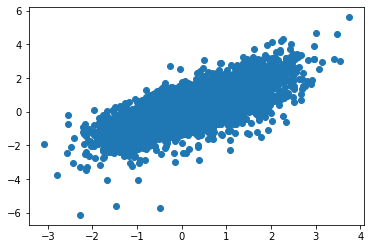

In [17]:
plt.scatter(mdl.predict(x), y)

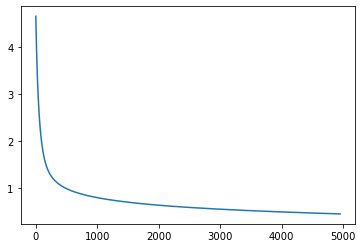

In [18]:
mdl.viz(skip_first = 50)

In [19]:
mdl.losses[-1]

0.444887187629615

In [20]:
from sklearn.linear_model import Ridge
baseline = Ridge().fit(x, y)
yhat = baseline.predict(x)
np.square(yhat - y).mean()

0.5648808816196393

In [21]:
mdl.loss(x, y[:,None])

0.4448478283361507